<a href="https://colab.research.google.com/github/florianrougier/pneumonia_detection/blob/master/Pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer vision applied to pneumonia detection

## Introduction

Computer vision has known a revolution lately. With the help of deep learning and amazing libraries/ frameworks.

One of the top domain were computer vision has been applied to is healthcare. 

Radiologists and medical imagery specialists are now totally outperformed by specialized systems.

Data is key to solve any machine learning tasks nowadays especially when the problem is complex enough to require the need of deep learning.

Deep Learning is this fantastic idea which basically consist in modeling a complex problem into a hierarchy of problems.

In this notebook, we will see an application of computer vision. 

Pneumonia (rappel du nombre de morts par an dans le monde)

Comparaison des performances d'un spécialiste et de celle d'une machine.

Parler des modèles préentrainés qui permettent à tout un chacun de créer une application

Dire que l'un des problèmes majeurs du deep learning et l'utilisation des ressources et de la consommation en énergie nécessaire à l'entrainement d'un réseau de neurones complexe.

Parler de l'architecture de inception v3.

The primiary goal of this notebook is to showcase an application of transfer learning and fine tuning on a kaggle dataset.

Tensorflow 2.0 rc1 is now available,
it's really easier now for beginners to start doing deep learning application.

Keras was developped by a top french researcher: francois chollet.
Now keras is packed inside tensorflow which is great. you don't need to install both keras and tensorflow. The syntax is almost identical too.



## Importing the dataset

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = 'florianrougier'
os.environ['KAGGLE_KEY'] = 'f7bcf61bf0f796180266259ec9bbac33'

In [89]:
# Searching through the whole list of datasets
!kaggle datasets list -s pneumonia

ref                                                               title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
paultimothymooney/chest-xray-pneumonia                            Chest X-Ray Images (Pneumonia)                        1GB  2018-03-24 19:41:59          22015  
parthachakraborty/pneumonia-chest-x-ray                           Pneumonia Chest X ray                                 1GB  2018-08-16 07:48:39            350  
vaillant/rsna-pneu-train-png                                      RSNA Pneumonia Detection Challenge Train PNGs         9GB  2018-09-21 00:02:41            198  
nih-chest-xrays/data                                              NIH Chest X-rays                                     42GB  2018-02-21 20:52:23          25749  
giuliasavorgnan/pytorchunetp

In [90]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 1.15G/1.15G [00:15<00:00, 72.4MB/s]
100% 1.15G/1.15G [00:15<00:00, 80.0MB/s]


In [91]:
!unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray.zip          


In [92]:
!unzip chest_xray.zip -d chest-xray-pneumonia

Archive:  chest_xray.zip
replace chest-xray-pneumonia/chest_xray/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace chest-xray-pneumonia/__MACOSX/chest_xray/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace chest-xray-pneumonia/chest_xray/test/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace chest-xray-pneumonia/__MACOSX/chest_xray/test/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace chest-xray-pneumonia/__MACOSX/chest_xray/test/PNEUMONIA/._person147_bacteria_706.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace chest-xray-pneumonia/__MACOSX/chest_xray/test/PNEUMONIA/._person100_bacteria_482.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person

In [0]:
# We know remove the zip files
!rm chest-xray-pneumonia.zip
!rm chest_xray.zip 

Note: We already have a train, a validation and a test folder

## Coding

Now it is time to do some coding. 

In [94]:
# Lets first install tensorflow 2.0.0.rc1
!pip install tensorflow-gpu==2.0.0.rc1

In [95]:
# We also install tqdm to get more information during the training
!pip install tqdm

## Stage 2: Dataset preprocessing

### Import project dependencies


In [7]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
tf.__version__

'2.0.0-rc1'

In [0]:
# Now let's define the path to our train, validation and test directories
dataset_path = "./chest-xray-pneumonia/chest_xray/"

In [0]:
# We have 3 datasets: train, validation and test

train_dir = os.path.join(dataset_path, "train")
validation_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

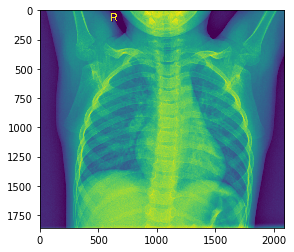

In [99]:
# Let's visualize some an example in the training set
example_img = mpimg.imread(train_dir + "/NORMAL/IM-0115-0001.jpeg")
plt.imshow(example_img)

Let's create a function to visualize a sample of images.

In [0]:
'''
Mandatory:
dataset: string, dataset from where we extract images
category: string, category within the dataset (NORMAL, PNEUMONIA)

Optional:
labeled: boolean, determine if images should be labeled
sample_size: int, number of images to display
'''
def plot_img(subset, category, labeled = False, sample_size = 6):
  
  full_path = dataset_path + subset + '/' + category
  
  # Check if sample_size is valid
  if (sample_size > len([file for file in os.listdir(full_path)])):
      print(len([file for file in os.listdir('.') if os.path.isfile(file)]))
      print("Not enough files in ", full_path)
      return
    
  # Define the figure size
  plt.figure(figsize=(18, 12))
  
  for i, file in enumerate(os.listdir(full_path)):

    # Check if number of images to display has been reached
    if(i >= sample_size):
      break
    img = mpimg.imread(full_path + '/' + file)
    plt.subplot(231 + i)

    if labeled:
      plt.title(file.split('-')[1])
    
    plt.imshow(img)


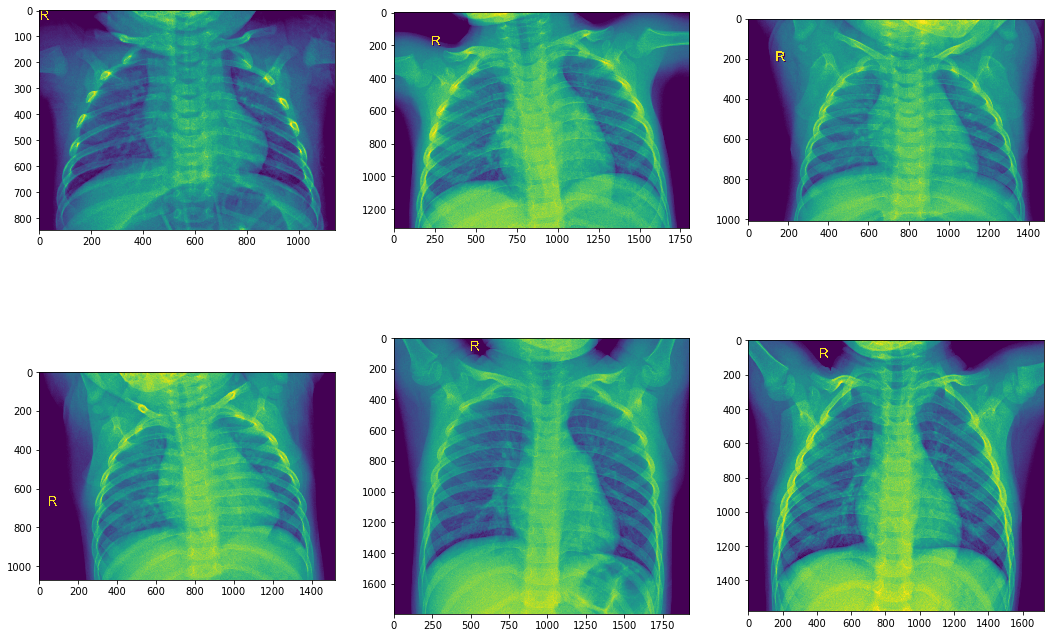

In [101]:
# Calling the above function
plot_img("train", "NORMAL")

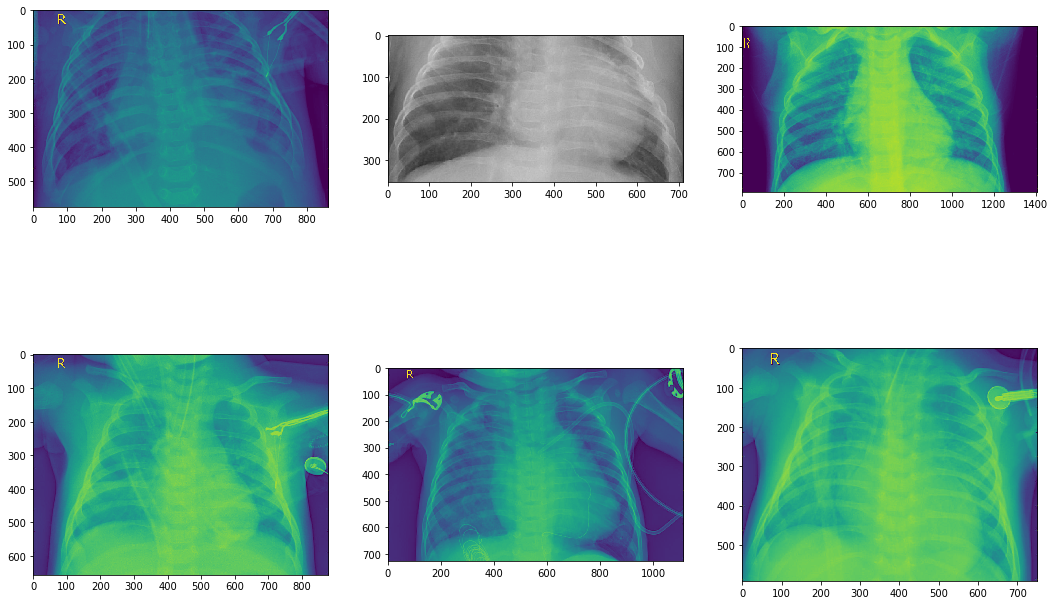

In [102]:
# With pneumonia cases
plot_img("train", "PNEUMONIA")

Now let's make a function to compare an iamge shwocasing pneumonia with another one which is normal

In [0]:
def compare_img(subset, labeled = False):
  path = dataset_path + subset
  
  # Taking a random sample from both the PNEUMONIA and the NORMAL directory
  random_pneumonia = np.random.choice(os.listdir(path + "/PNEUMONIA"))
  random_normal = np.random.choice(os.listdir(path + "/NORMAL"))
  
  # Figure size
  fig=plt.figure(figsize=(16, 16))


  # Displaying images
  a = fig.add_subplot(1, 2, 1)
  normal = mpimg.imread(path + "/NORMAL/" + random_normal)
  image1 = plt.imshow(normal)
  
  
  # Option to show the label 
  if labeled:
    a.set_title('NORMAL')
    
  a = fig.add_subplot(1, 2, 2)
  pneumonia = mpimg.imread(path + "/PNEUMONIA/" + random_pneumonia)
  image2 = plt.imshow(pneumonia)
  
  # Option to show the label 
  if labeled:
    a.set_title('PNEUMONIA')
  

  plt.show()

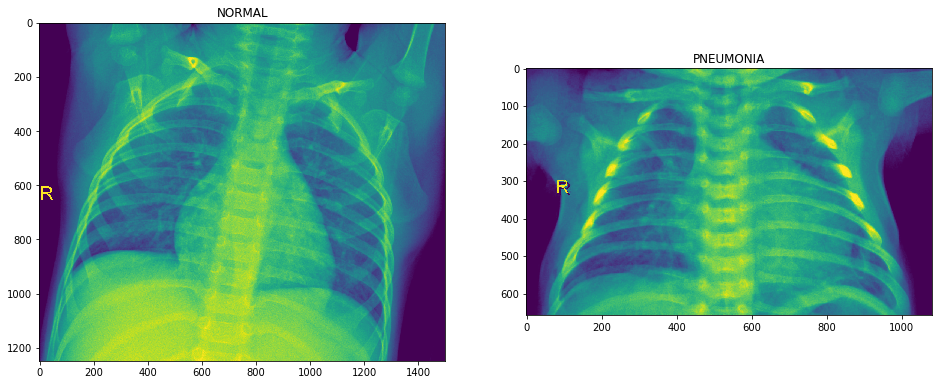

In [104]:
# Let's compare one image showasing pneumonia and one normal
compare_img("train", labeled = True)

## Building the model

### Loading the pre-trained model (InceptionV3)

In [0]:
IMG_SHAPE = (299, 299, 3)

In [0]:
base_model = tf.keras.applications.InceptionV3(input_shape = IMG_SHAPE, include_top = False, weights="imagenet")

### Base architecture of the inceptionV3 model

In [107]:
base_model.summary() # This is quite a complex architecture

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 149, 149, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 149, 149, 32) 0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

### Freezing the base model

In [0]:
base_model.trainable = False

### Defining the custom head for our network

In [109]:
base_model.output

<tf.Tensor 'mixed10_2/Identity:0' shape=(None, 8, 8, 2048) dtype=float32>

Using a pooling layer to reduce the output dimension

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

In [111]:
global_average_layer

<tf.Tensor 'global_average_pooling2d_2/Identity:0' shape=(None, 2048) dtype=float32>

In [0]:
prediction_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')(global_average_layer)

### Defining the model

In [0]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

In [114]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 149, 149, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 149, 149, 32) 0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

### Compiling the model

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### Creating Data Generators

Resizing images

    Big pre-trained architecture support only certain input sizes.

For example: InceptionV3 (architecture that we use) supports: (299, 299)

In [0]:
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_valid = ImageDataGenerator(rescale=1/255.)

In [14]:
train_generator = data_gen_train.flow_from_directory(train_dir, target_size=(299,299), batch_size=128, class_mode="binary")

Found 5216 images belonging to 2 classes.


In [15]:
valid_generator = data_gen_valid.flow_from_directory(validation_dir, target_size=(299,299), batch_size=128, class_mode="binary")

Found 16 images belonging to 2 classes.


In [16]:
train_generator = data_gen_valid.flow_from_directory(test_dir, target_size=(299,299), batch_size=128, class_mode="binary")

Found 624 images belonging to 2 classes.


### Training the model

Note: We don't have enough validation data in my opinion, the accuracy on the validation set will be a bit irrelevant

In [0]:
model.fit_generator(train_generator, epochs=10, validation_data=valid_generator)

Epoch 1/10


### Transfer learning model evaluation

In [0]:
valid_loss, valid_accuracy = model.evaluate_generator(valid_generator)

In [0]:
print("Accuracy after transfer learning: {}".format(valid_accuracy))

### Plotting the results

The below function will compare the true values with the predicted ones using the validation which contains only 16 images (8 for both classes)

In [0]:
def compare_results(root_path, generator):

  #predictions = model.predict_generator(valid_generator) # Return numpy array of predictions
  
  fig = plt.figure(figsize=(18, 8))
 
  for subdir, dirs, files in os.walk(root_path):
    for i, file in enumerate(os.listdir()):
      img = plt.imread(file)
      plt.title()
      plt.subplot(241 + i)
      plt.imshow(img)    

In [0]:
compare_results(validation_dir, valid_generator)

### Saving the model

In [0]:
model.save("test_model.h5") # neural net weights

import json


with open('architecture.json', 'w') as json_file:
    json.dump(model, json_file)

## Fine tuning

There are a few pointers:

- DO NOT use Fine tuning on the whole network; only a few top layers are enough. In most cases, they are more specialized. The goal of the Fine-tuning is to adopt that specific part of the network for our custom (new) dataset.
- Start with the fine tunning AFTER you have finished with transfer learning step. If we try to perform Fine tuning immediately, gradients will be much different between our custom head layer and a few unfrozen layers from the base model. 

### Un-freeze a few top layers from the model

In [0]:
base_model.trainable = True

In [0]:
print("Number of layers in the base model: {}".format(len(base_model.layers)))